In [1]:
# from MergeEtLireEtHisto import lirefichierh5
%matplotlib widget
from MergeEtLireEtHisto import lirefichierh5
from MergeEtLireEtHisto import histogrammesfichierfinal

import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import save_model
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
#Charger les données
iq_data = np.load('iq_data.npy')
particle_shape_data_string = np.load('particle_shape_data.npy')
particle_size_data = np.load('particle_size_data.npy')
atom_type_data = np.load('atom_type_data.npy')


print ('iq_data' , iq_data.shape)
print ('particle_shape_data' , particle_shape_data_string.shape)
print ('particle_size_data' , particle_size_data.shape)
print ('atom_type_data' , atom_type_data.shape)

nbre_simu = iq_data.shape[0]
print(nbre_simu,' simulations')

iq_data (5888, 2000)
particle_shape_data (5888, 1)
particle_size_data (5888, 3)
atom_type_data (5888, 1)
5888  simulations


In [3]:
# générer les valeurs de q comme dans la simu
qmin=0.001
qmax=20
qstep=0.002
q=np.arange(qmin, qmax, qstep)

#diminuer la gamme en q
# qmin_new = 0.001
# qmax_new = 2
qmin_new= 0.001
qmax_new= 4

indices = np.where((q >= qmin_new) & (q <= qmax_new ))
q_new = q[indices]
print('avant : ',q.shape)
print('apres : ',q_new.shape)

# Répéter le tableau pour obtenir les dimensions souhaitées
q_data = np.tile(q_new, (nbre_simu, 1))

avant :  (10000,)
apres :  (2000,)


In [4]:
print('avant : ', iq_data.shape)
iq_data = iq_data[:, indices[0]]

print('apres : ', iq_data.shape)

avant :  (5888, 2000)
apres :  (5888, 2000)


5888


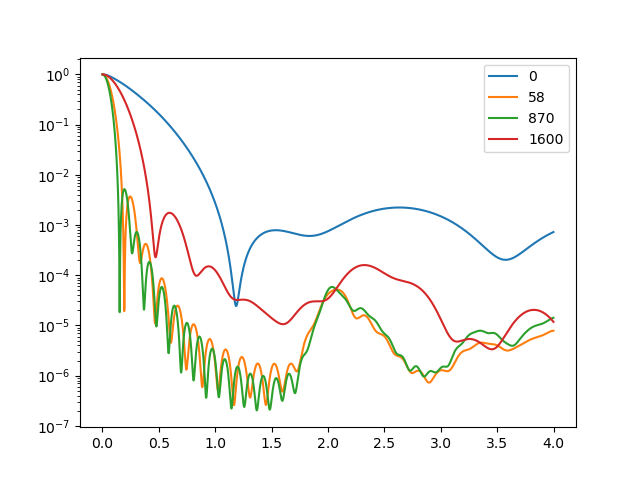

In [5]:
#previsualisation de quelques i de q
longueur_i = iq_data.shape[0] 
print(longueur_i)
fig,ax = plt.subplots()
# Créez une liste de titres correspondant à chaque courbe

for k in  (0,58,870,1600):
    ax.set_yscale('log')
    ax.plot(q_data[k],iq_data[k],label = str(k))
    ax.legend()

In [6]:
nbre_simu = iq_data.shape[0]
print(nbre_simu)

#normalisation
# Calcul du maximum en ignorant les valeurs nulles

val_lmax = np.max(iq_data,axis=1,keepdims=True)

# val_lmax = np.max(iq_data,axis=1)
iq_data = iq_data / val_lmax

5888


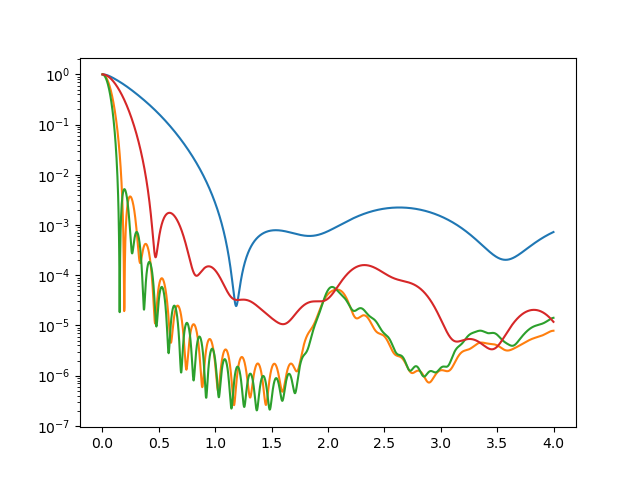

In [7]:
#previsualisation de quelques i de q
fig,ax = plt.subplots()
for k in (0,58,870,1600):
    ax.set_yscale('log')
    ax.plot(q_data[k],iq_data[k])

In [8]:
print(particle_size_data.shape)
print(particle_size_data)
# dans un premier temps, on va predire uniquement la premiere valeur
taille = particle_size_data[:,0]
print(taille)

(5888, 3)
[[ 2.  0.  0.]
 [ 3.  0.  0.]
 [ 3.  0.  0.]
 ...
 [ 9.  0.  0.]
 [10.  0.  0.]
 [ 2.  0.  0.]]
[ 2.  3.  3. ...  9. 10.  2.]


In [9]:
# Diviser les données en ensembles d'entraînement et de test


X_train, X_test, y_train, y_test = train_test_split(iq_data, taille, test_size=0.2, random_state=42)

In [10]:
print ('y_train.shape = ',y_train.shape)

print ('y_test.shape = ',y_test.shape)

# Remodelage des données X_train
X_train = X_train.reshape((X_train.shape[0], iq_data.shape[1], 1))
# Remodelage des données X_test
X_test = X_test.reshape((X_test.shape[0], iq_data.shape[1], 1))
print ('X_train.shape = ',X_train.shape)
print ('X_test.shape = ',X_test.shape)
print('y_test',y_test)

y_train.shape =  (4710,)
y_test.shape =  (1178,)
X_train.shape =  (4710, 2000, 1)
X_test.shape =  (1178, 2000, 1)
y_test [7. 6. 9. ... 7. 8. 8.]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Créez une instance de LabelEncoder
label_encoder = LabelEncoder()



y_train_encoded = to_categorical(y_train - 1, num_classes=10)
y_test_encoded = to_categorical(y_test - 1, num_classes=10)


In [12]:
print(y_test[0],'converti en ',y_test_encoded[0])



7.0 converti en  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [13]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential()

model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(2000, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))  # 10 unités pour 10 classes, activation softmax

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1998, 32)          128       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 999, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 997, 64)           6208      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 498, 64)          0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 31872)             0         
                                                                 
 dense (Dense)               (None, 128)               4

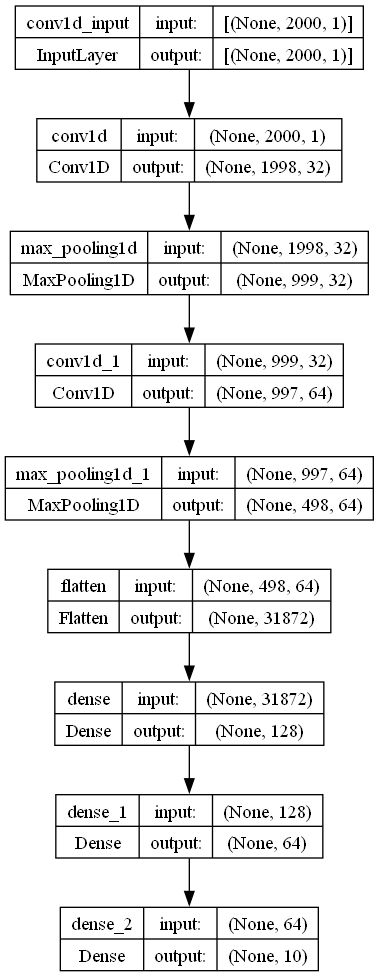

In [14]:
from tensorflow.keras.utils import plot_model
# Utiliser plot_model pour visualiser le modèle
plot_model(model, to_file="modelTaille.png", show_shapes=True, show_layer_names=True)

In [19]:
history = model.fit(X_train, y_train_encoded, epochs=200, batch_size=32, validation_data=(X_test, y_test_encoded))


Epoch 1/200
148/148 [==============================] - 7s 39ms/step - loss: 1.7440 - accuracy: 0.2648 - val_loss: 1.6298 - val_accuracy: 0.2547
Epoch 2/200
148/148 [==============================] - 5s 36ms/step - loss: 1.5588 - accuracy: 0.2834 - val_loss: 1.5271 - val_accuracy: 0.2980
Epoch 3/200
148/148 [==============================] - 5s 37ms/step - loss: 1.5175 - accuracy: 0.3036 - val_loss: 1.5195 - val_accuracy: 0.2937
Epoch 4/200
148/148 [==============================] - 6s 38ms/step - loss: 1.5135 - accuracy: 0.3070 - val_loss: 1.5093 - val_accuracy: 0.2980
Epoch 5/200
148/148 [==============================] - 7s 46ms/step - loss: 1.4905 - accuracy: 0.3138 - val_loss: 1.5082 - val_accuracy: 0.2997
Epoch 6/200
148/148 [==============================] - 6s 42ms/step - loss: 1.4793 - accuracy: 0.3206 - val_loss: 1.5010 - val_accuracy: 0.3081
Epoch 7/200
148/148 [==============================] - 7s 45ms/step - loss: 1.4651 - accuracy: 0.3229 - val_loss: 1.4670 - val_accuracy:

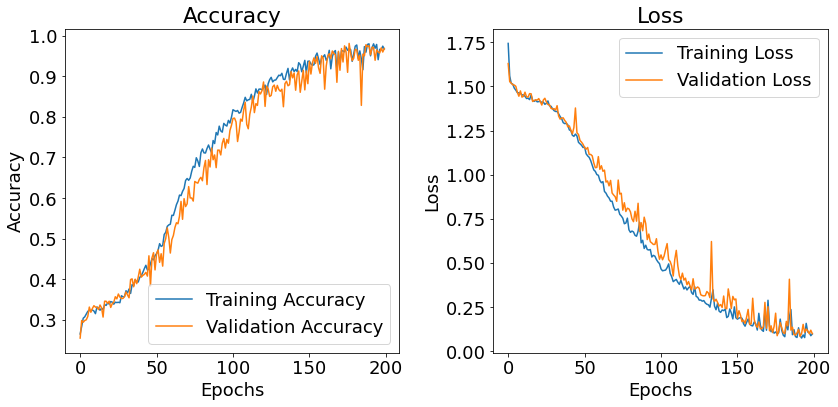

In [61]:
# Obtenez les valeurs d'accuracy et de perte depuis l'historique
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Créez un sous-graphique avec 1 ligne et 2 colonnes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
plt.rc('font', size=18) 
# Tracez l'accuracy sur le sous-graphique de gauche
ax1.plot(accuracy, label='Training Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Tracez la perte sur le sous-graphique de droite
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

# Ajustez l'espacement entre les sous-graphiques
plt.tight_layout()
plt.savefig('apprentissage_size.png')
# Affichez le graphique
plt.show()

In [21]:
predictions = model.predict(X_test)

37/37 [==============================] - 0s 8ms/step


In [22]:
from sklearn.metrics import accuracy_score

# Convertissez les prédictions en classes (indices) en prenant l'indice de la classe avec la probabilité la plus élevée
predicted_classes = np.argmax(predictions, axis=1)

# Comparez les classes prédites aux vraies classes du jeu de test
true_classes = np.argmax(y_test_encoded, axis=1)

# Calculez l'accuracy en utilisant la fonction accuracy_score
accuracy = accuracy_score(true_classes, predicted_classes)

print("Accuracy on test set:", accuracy)


Accuracy on test set: 0.9685908319185059


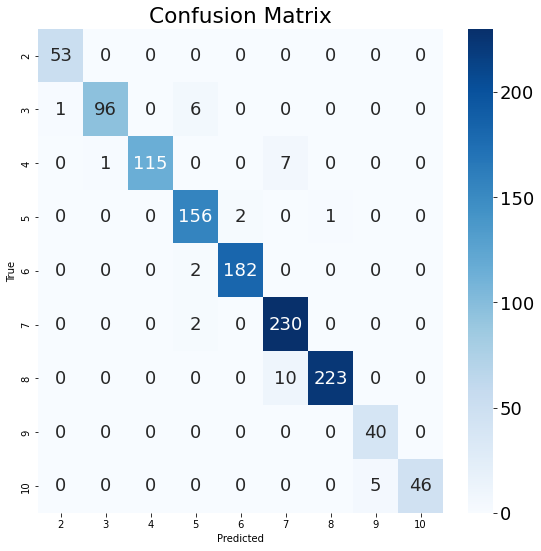

In [23]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# on veut predire de 2 à 10 couches, il faut donc décaler les etiquettes, sinon prediction de 0 à 8


# Calculer la matrice de confusion
confusion_mtx = confusion_matrix(true_classes, predicted_classes)

# Créer une figure avec deux sous-graphiques
fig, ax = plt.subplots(figsize=(8, 8))
plt.rc('font', size=18)
# Tracer la matrice de confusion
# sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[0])
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')



# Définir les étiquettes des axes x et y , on veut predire de 2 à 10 couches, 


ax.set_xticklabels(np.arange(2, 11))  # Modifiez les valeurs ici pour ajuster l'échelle
ax.set_yticklabels(np.arange(2, 11))

plt.tight_layout()
plt.savefig('confusion_matrix_size.png')
plt.show()


Text(0.5, 1.0, 'Normalized Confusion Matrix')

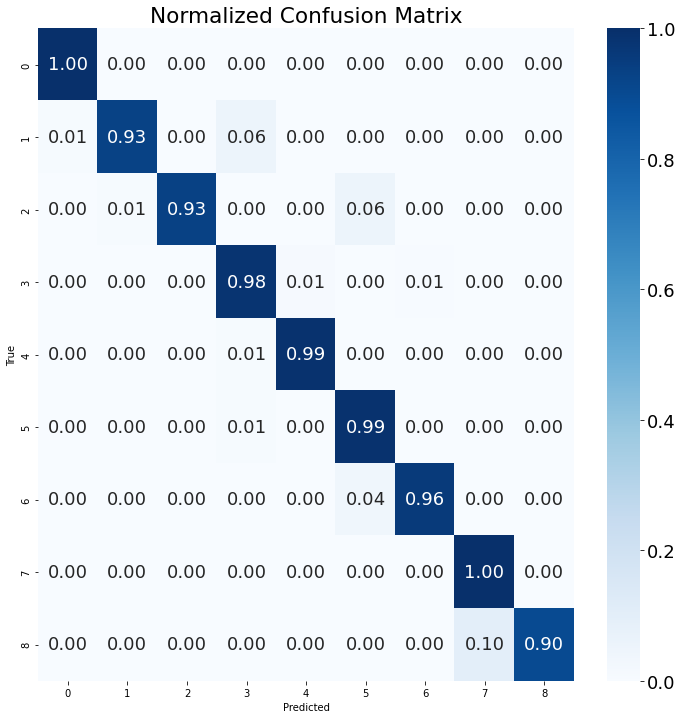

In [24]:

# Tracer la matrice de confusion normalisée
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 12))
plt.rc('font', size=18)
confusion_mtx_norm = confusion_mtx.astype('float') / confusion_mtx.sum(axis=1)[:, np.newaxis]
# sns.heatmap(confusion_mtx_norm, annot=True, cmap='Blues', ax=axes[1])
sns.heatmap(confusion_mtx_norm, annot=True, fmt='.2f', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Normalized Confusion Matrix')

2.0
10.0


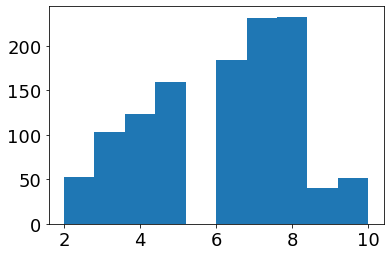

In [25]:
fig,ax = plt.subplots()
ax.hist(y_test)
print(np.min(y_test))
print(np.max(y_test))
